Program written by: Ningyou Li, 20307142; This program 

In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import pandas as pd
import sys
import nrrd
import os
%config Completer.use_jedi = False

In [188]:
# read image
img = sitk.ReadImage('Case11.mhd')
goldenStandard_img = sitk.ReadImage('Case11_segmentation.mhd')

In [3]:
def image_Info(image):
    """
    :param image: the input image read by SimpleITK
    :return: None
    This function prints the properties of the image. Properties include: size, spacing, origin, direction, pixel type
    """
    print('Size:', image.GetSize()) #size
    print('Space:', image.GetSpacing()) #space
    print('Origin:', image.GetOrigin()) #origin
    print('Direction:', image.GetDirection()) #direction
    print('Pixel Type:', image.GetPixelIDTypeAsString()) #pixel type
    
image_Info(img)

Size: (512, 512, 45)
Space: (0.312499, 0.312502, 2.79998)
Origin: (-99.4454, -77.9882, -58.7955)
Direction: (0.999637, -7.58933e-19, 0.0269276, 0.00448624, 0.986045, -0.166417, -0.0265512, 0.166477, 0.985688)
Pixel Type: 16-bit signed integer


In [4]:
# some information about pixels
stat_filter = sitk.StatisticsImageFilter()
stat_filter.Execute(img) #the output is not an image object but it has information
print('min pixel value: ',stat_filter.GetMinimum())
print('max pixel value: ',stat_filter.GetMaximum())

min pixel value:  0.0
max pixel value:  27479.0


In [5]:
image_Info(goldenStandard_img)

Size: (512, 512, 45)
Space: (0.312499, 0.312502, 2.79998)
Origin: (-99.4454, -77.9882, -58.7955)
Direction: (0.999637, -1.51787e-18, 0.0269276, 0.00448624, 0.986045, -0.166417, -0.0265512, 0.166477, 0.985688)
Pixel Type: 8-bit signed integer


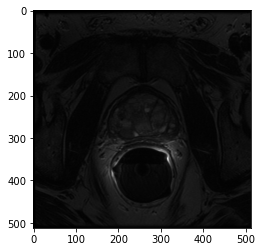

In [6]:
plt.imshow(sitk.GetArrayFromImage(img[:,:,22]), cmap='gray') 

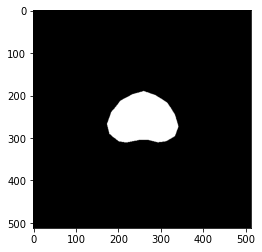

In [281]:
plt.imshow(sitk.GetArrayFromImage(goldenStandard_img[:,:,22]), cmap='gray') 

In [10]:
# Set external viewer to 3D slicer and Open with external viewer
image_viewer = sitk.ImageViewer()
image_viewer.SetApplication('C:/Users/Linda/AppData/Local/NA-MIC/Slicer 4.11.20210226/Slicer.exe')
image_viewer.Execute(img)

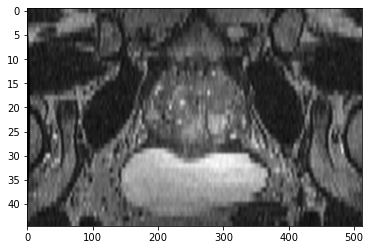

In [9]:
plt.imshow(sitk.GetArrayFromImage(img[:,256,:]),cmap='gray', aspect='auto') 

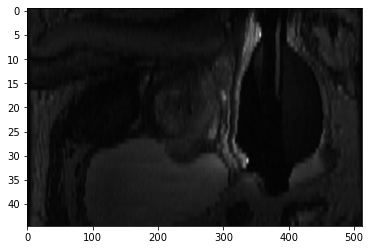

In [10]:
plt.imshow(sitk.GetArrayFromImage(img[256,:,:]),cmap='gray',aspect='auto') 

In [618]:
def prostate_segmenter(image, glambda=0.2, seed_pts=(259,253,22), TimeStep=0.125, conductance=0.3, sigma=0.1,alpha=-0.3, beta=2.0, stoppingValue=480, upperThreshold=800, lowerThreshold=0):
    slice_no = round(image.GetSize()[2]/2)
    img = sitk.Cast(image, sitk.sitkFloat32)
    # brighten the image using gamma filter to show more details in dark
    filtered_img = ((image/255)**glambda) # lambda<0
    gamma_img = sitk.RescaleIntensity(filtered_img,0,255)
    # smoothing filter
    smoothing = sitk.CurvatureAnisotropicDiffusionImageFilter()
    smoothing.SetTimeStep(TimeStep)
    #smoothing.SetNumberOfIterations(1)
    smoothing.SetConductanceParameter(conductance)
    smoothingOutput = smoothing.Execute(gamma_img)
    # gradient filter
    gradientMagnitude = sitk.GradientMagnitudeRecursiveGaussianImageFilter()
    gradientMagnitude.SetSigma(sigma)
    gradientMagnitudeOutput = gradientMagnitude.Execute(smoothingOutput)
    # sigmoid curve filter
    sigmoid = sitk.SigmoidImageFilter()
    sigmoid.SetOutputMinimum(0.0)
    sigmoid.SetOutputMaximum(1.0)
    sigmoid.SetAlpha(alpha)
    sigmoid.SetBeta(beta)
    sigmoid.DebugOn()
    sigmoidOutput = sigmoid.Execute(gradientMagnitudeOutput)
    # fast marching
    fastMarching = sitk.FastMarchingImageFilter()
    #trialPoint = (259,253,22)
    fastMarching.AddTrialPoint(seed_pts)
    fastMarching.SetStoppingValue(stoppingValue)
    fastMarchingOutput = fastMarching.Execute(sigmoidOutput)
    # thresholding
    thresholder = sitk.BinaryThresholdImageFilter()
    thresholder.SetLowerThreshold(lowerThreshold)
    thresholder.SetUpperThreshold(upperThreshold)
    thresholder.SetOutsideValue(0)
    thresholder.SetInsideValue(255)

    plt.figure(figsize=(10,5))
    plt.imshow(sitk.GetArrayFromImage(result_img[:,:,slice_no]))
    return result_img

In [609]:
def saveImage(image, fileName='my_segmentation.nrrd'):
    writer = sitk.ImageFileWriter()
    writer.SetFileName(fileName)
    writer.Execute(image)

In [615]:
def overlay_visulize(image, mask_img):
    slice_no = round(image.GetSize()[2]/2)
    overlay_image = sitk.LabelOverlay(image[:,:,slice_no], mask_img[:,:,slice_no])
    plt.figure(figsize=(10,5))
    #plt.imshow(out.astype('uint8'))
    plt.imshow(sitk.GetArrayFromImage(overlay_image).astype(np.uint8))
    plt.show()
    return overlay_image
# overlay图像有点问题

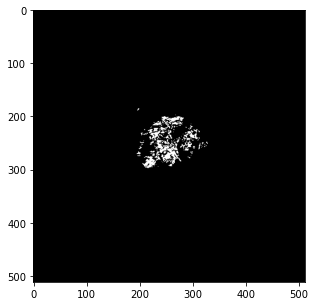

In [603]:
filtered_img = prostate_segmenter(img)

In [611]:
saveImage(filtered_img, fileName='my_segmentation.nrrd')

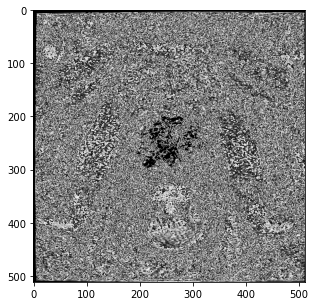

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x000002BAD5D3C750> >

In [616]:
overlay_visulize(img, filtered_img)

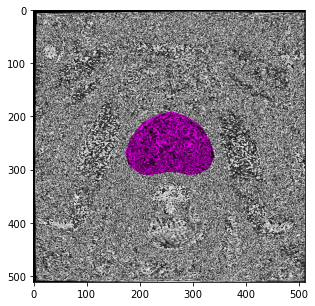

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x000002BAD4542030> >

In [617]:
overlay_visulize(img, goldenStandard_img)

# Part b

In [621]:
def seg_eval_dice(filtered_img, img):
    dice_dist = sitk.LabelOverlapMeasuresImageFilter()
    dice_dist.Execute(img>0.5, filtered_img>0.5)
    dice = dice_dist.GetDiceCoefficient()
    print('Dice evaluation: ', dice)
    return dice

In [626]:
def seg_eval_hausdorff(filtered_img, img):
    #img = sitk.Cast(img, sitk.sitkUInt8)
    #img = sitk.Cast(img, sitk.sitkFloat32)
    hausdorffcomputer = sitk.HausdorffDistanceImageFilter()
    hausdorffcomputer.Execute(img>0.5, filtered_img>0.5)
    #AverageHD = hausdorffcomputer.GetAverageHausdorffDistance()
    HD = hausdorffcomputer.GetHausdorffDistance()
    print('HausdorffDistance:', HD)
    return HD

In [537]:
seg_eval_dice(filtered_img, img)

Dice evaluation:  0.005156458904136547


0.005156458904136547

In [538]:
seg_eval_dice(goldenStandard_img, img)

Dice evaluation:  0.03868918930286945


0.03868918930286945

In [578]:
seg_eval_dice(result_img, img)

Dice evaluation:  0.10119761742129353


0.10119761742129353

In [552]:
seg_eval_hausdorff(filtered_img, img)

HausdorffDistance: 107.11789231473128


107.11789231473128

In [540]:
seg_eval_hausdorff(goldenStandard_img, img)

HausdorffDistance: 105.10410644156092


105.10410644156092

# Part C


In [470]:
def findMaxArea(seg_img):
    #img_array = sitk.GetArrayFromImage(seg_img)
    area = 0
    area_lst = []
    for slice_no in range(seg_img.GetSize()[2]):
        img_array = sitk.GetArrayFromImage(seg_img[:,:,slice_no])
        pixels = len(np.column_stack(np.where(img_array > 0)))
        # Calculate the area of the prostate
        new_area = (seg_img[:,:,slice_no].GetSpacing()[0]*seg_img[:,:,slice_no].GetSpacing()[1])*pixels
        area_lst.append(new_area)
    slices = area_lst.index(max(area_lst))
    print('max area of slide', slices, 'is', max(area_lst))
    return slices

In [471]:
findMaxArea(seg_img)

max area of slide 21 is 1579.887868092644


21

In [425]:
def get_target_loc(seg_img):
    slide_no = findMaxArea(seg_img)
    segImage_array = sitk.GetArrayFromImage(seg_img[:,:,slide_no])
    x = np.mean(np.column_stack(np.where(segImage_array > 0)[1]))
    y = np.mean(np.column_stack(np.where(segImage_array > 0)[0]))
    print('centroid in index:', (x,y,slide_no))
    physical = seg_img.TransformContinuousIndexToPhysicalPoint((x,y,slide_no))
    print('centroid in actual dimension:', physical)
    return physical

In [541]:
centroid_pt = get_target_loc(goldenStandard_img)

max area of slide 21 is 1579.887868092644
centroid in index: (257.1432809988874, 255.87198664853506, 21)
centroid in actual dimension: (-17.53421985831598, -8.568290147191846, 10.34055056923868)


In [542]:
def overlay_target(coordinate, image):
    slide_no = findMaxArea(seg_img)
    image_array = sitk.GetArrayFromImage(image[:,:,slide_no])
    pixel_coor = image.TransformPhysicalPointToIndex(coordinate)
    plt.imshow(image_array, cmap='gray')
    plt.annotate('X', xy=(pixel_coor[0],pixel_coor[1]),color= 'red')
    plt.show()

max area of slide 21 is 1579.887868092644


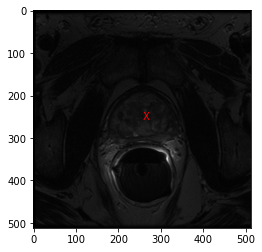

In [543]:
overlay_target(centroid_pt, img)

# Part D

In [472]:
def pixel_extract(image, point, width):
    sub = (image.TransformPhysicalPointToIndex((point[0]-width/2, point[1]-width/2, point[2]-width/2)))
    add = (image.TransformPhysicalPointToIndex((point[0]+width/2, point[1]+width/2, point[2]+width/2)))
    slide_lst = list(range(sub[2], (add[2])+1))
    pixel_lst = []
    for slide_no in slide_lst:
        slide_array = sitk.GetArrayFromImage(image[sub[0]:add[0], sub[1]:add[1], slide_no])
        pixel_lst.append(slide_array.flatten())
    flat_list = [item for sublist in pixel_lst for item in sublist]
    print('\nend of pixel extacting')
    return flat_list

In [544]:
result = pixel_extract(img, centroid_pt, 6)


end of pixel extacting


In [465]:
def plotBoxplot(data, point):
    plt.boxplot(data)
    plt.xlabel(str(point))
    plt.ylabel('Pixel Intensity')
    plt.show()
    return None

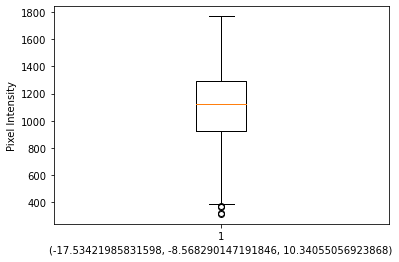

In [466]:
plotBoxplot(result, centroid_pt)

In [629]:
def main():
    # read image
    img = sitk.ReadImage('Case11.mhd')
    goldenStandard_img = sitk.ReadImage('Case11_segmentation.mhd')
    # segmentation
    filtered_img = prostate_segmenter(img)
    # save segmentation
    saveImage(filtered_img, fileName='my_segmentation.nrrd')
    # visulize overlay images
    print('my segmentation:')
    overlay_visulize(img, filtered_img)
    #saveImage(overlay_img, fileName='overlay_mySegmentation.jpg')
    print('golden standard:')
    overlay_visulize(img, goldenStandard_img)
    #saveImage(overlay_golden, fileName='overlayGolden.jpg')
    # dice evaluations
    print('my segmentation:')
    seg_eval_dice(filtered_img, img)
    print('golden standard:')
    seg_eval_dice(goldenStandard_img, img)
    # hausdorff evaluations
    print('my segmentation:')
    seg_eval_hausdorff(filtered_img, img)
    print('golden standard:')
    seg_eval_hausdorff(goldenStandard_img, img)
    # find centroid point
    centroid_pt = get_target_loc(goldenStandard_img)
    # plot red X on image
    overlay_target(centroid_pt, img)
    # extract pixel intensity array
    result = pixel_extract(img, centroid_pt, 6)
    # boxplot of pixel intensity
    plotBoxplot(result, centroid_pt)

my segmentation:


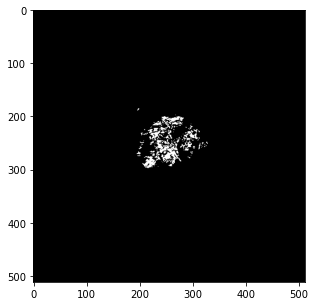

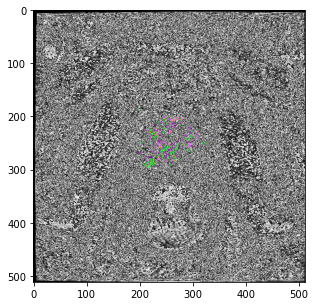

golden standard:


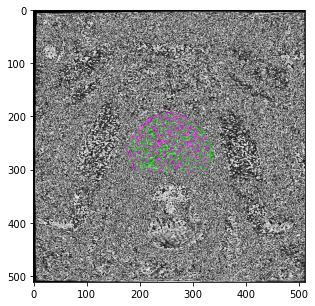

my segmentation:
Dice evaluation:  0.10119761742129353
golden standard:
Dice evaluation:  0.03868918930286945
my segmentation:
HausdorffDistance: 100.85009908963822
golden standard:
HausdorffDistance: 105.10410644156092
max area of slide 21 is 1579.887868092644
centroid in index: (257.1432809988874, 255.87198664853506, 21)
centroid in actual dimension: (-17.53421985831598, -8.568290147191846, 10.34055056923868)
max area of slide 21 is 1579.887868092644


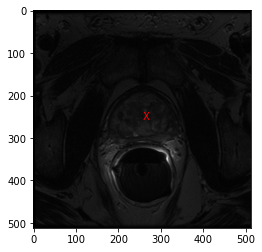


end of pixel extacting


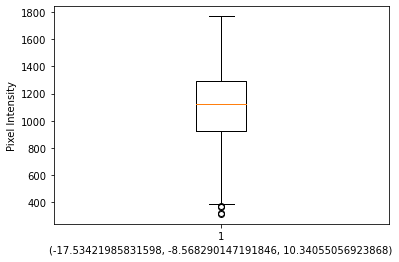

In [630]:
main()

In [628]:
https://github.com/NingyouLi/miniProject_NingyouLi.git

SyntaxError: invalid syntax (<ipython-input-628-e4234b678c54>, line 1)